# AI for Quantum: Compiling Unitaries Using Diffusion Models
$\renewcommand{\ket}[1]{|#1\rangle}$

AI is a powerful tool for enabling some of the hardest aspects of a hybrid quantum classical workflow including QEC, compilation, calibration, etc. (See the review paper [here](https://arxiv.org/abs/2411.09131) for more AI for Quantum use cases). Compiling quantum algorithms is an incredible challenge which involves identifying a target unitary, finding an appropriate circuit representation, and then efficiently running the circuit on highly contraining hardware.

In recent papers  [Quantum circuit synthesis with diffusion models](https://doi.org/10.1038/s42256-024-00831-9) and [Synthesis of discrete-continuous quantum circuits with multimodal diffusion models](https://arxiv.org/abs/2506.01666), it was demonstrated how diffusion models can be used for unitary synthesis.  This lab will explore the problem of unitary synthesis, introduce a diffusion model used in the work, and allow you to compile circuits of your own using AI.

**Pre-requisites:**  No experience with diffusion models is necessary. However, this notebook will not provide a detailed discussion on diffusion models or their construction. For curious readers, we suggest NVIDIA's Deep Learning Institute [course](https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+S-FX-14+V1) on diffusion models. As far as quantum prerequisites, familiarity with the basics of quantum computing like gates, state vectors, etc. is required. If you are not familiar with these concepts, please complete the [Quick Start to Quantum Computing](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum)  course first.


**What you'll do:**
* Learn the basics of unitary synthesis and try to compile a unitary by hand
* Encode quantum circuits as inputs for the diffusion model
* Synthesize quantum circuits corresponding to a given unitary matrix with a diffusion model
* Evaluate if the obtained circuit is accurate
* Filter better quantum circuits
* Sample a circuit using a noise model


Let's begin with installing the relevant packages.

In [1]:
# Uncomment and execute the following lines if you are working in an environment without these packages already installed
#!pip install cudaq
#!pip install genQC==0.1.0
#!pip install torch==2.8.0
#!pip install numpy==2.2.6

In [2]:
import functools
import itertools
import numpy as np
import torch
import cudaq
import matplotlib.pyplot as plt

import genQC
from genQC.imports import *
from genQC.pipeline.diffusion_pipeline import DiffusionPipeline
from genQC.inference.export_cudaq import genqc_to_cudaq
import genQC.inference.infer_compilation as infer_comp
import genQC.util as util

# Fixed seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

## The Challenge of Unitary Synthesis and Compilation

In a sense, quantum computing is extremely simple, corresponding to the multiplication of a unitary matrix with a state vector to produce the desired quantum state that solves a problem.  In the example below we use the ordering $\ket{q_0q_1q_2}$. The initial state vector is $\ket{000}$ and the state produced after multiplying by the unitary matrix $U$ is $\ket{111}$.

$$
\underbrace{
\begin{pmatrix}
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{pmatrix}
}_{\text{Unitary } U}
\underbrace{
\begin{pmatrix}
1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0
\end{pmatrix}
}_{|000\rangle}
\quad = \quad
\underbrace{
\begin{pmatrix}
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1
\end{pmatrix}
}_{|111\rangle}
$$

The quantum circuit drawn below represents a **synthesis** of this unitary matrix.  That is, it produces the same result as multiplying by $U$ above, regardless of the initial state.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main/images/toffoli-example-circuit.jpg?raw=true)


Wrapped up in this simple picture of unitary matrices and quantum circuits is incredible complexity which makes quantum computing so difficult.

**Scaling:** First, the unitary matrix corresponding to a quantum circuit is huge, with $2^n \times 2^n$ entries where $n$ is the number of qubits in the circuit. The matrix cannot be stored naively on any classical computer in its entirely for more than about 25 qubits.

**Identifying the unitary:** Second, it is far from obvious in many cases what particular unitary matrix will solve a problem.  Consider methods like VQE where the entire goal is to identify what sort of parameterized circuit (unitary matrix) solves the given problem.

**Executing on a quantum device:** Finally, even if the unitary required is known, implementing it on a physical QPU requires it to be **synthesized (or compiled)** into a set of discrete gate operations compatible with the device.  Furthermore decisions needs to be made concerning how these gates are performed and in which order to ensure that performance is achieved and bottlenecks are avoided.

This is extremely challenging and gets even worse when considering the fact that different QPUs have different gate sets and hardware constraints, quantum error correction protocols add addition overhead, and time constraints require not only that an accurate circuit be synthesized, but that it is as simple as possible.

It is no wonder why circuit synthesis is considered a leading AI for quantum use case as AI's aptitude for complex pattern recognition could provide a powerful means for compiling the unitaries necessary to run quantum algorithms at scale.

In this lab, you will explore unitary synthesis and learn how to generate valid circuits given a target unitary.

> **Exercise 1**:
> 
> To get a sense for how difficult compilation is, try to compile the state of a single qubit by hand with this interactive <a href="https://nvidia.github.io/cuda-q-academic/ai-for-quantum/widgets/unitary_widget.html" target="_blank">game</a>.
>
>Instructions for the game: You are given a random unitary and presented with two Bloch spheres depicting its action on the $\ket{0}$ and $\ket{1}$ states.  Your job is to apply gate operations to get as close as possible to the target unitary. You will notice, that even when you can see exactly what each gate does, it is not obvious how to match the initial state exactly.  Even if action on a single state is correct, the unitary may still be incorrect as it must properly operate on all basis states.

## An Overview of the Diffusion Model

Though many AI techniques have been explored for circuit synthesis, the rest of this lab will look at recent work [(Fürrutter, et al., 2024)](https://doi.org/10.1038/s42256-024-00831-9) that used diffusion models for the task. We'll begin with a general overview of diffusion models and then discuss the specific advantages they offer for circuit synthesis.

This section is not a comprehensive or particularly deep lesson on diffusion models for which we point the reader to [this course](https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+S-FX-14+V1).  To build intuition, we will first use the common example of image generation before applying these concepts to our main topic of unitary synthesis.


### The Core Idea: Denoising Images

The primary objective of a diffusion model is to generate high-quality samples by learning to reverse a noise-adding process, rather than learning the data distribution directly. The training begins with a clean dataset — in this case, images — to which Gaussian noise is incrementally added in a "forward process."


To reverse this, the model employs a U-net architecture to learn the "reverse process" of denoising. The U-net is trained to take a noisy image as input and predict the specific noise pattern that was added to it. The model's parameters are optimized by minimizing a loss function that measures the difference between the predicted noise and the actual noise.

It's important to note that the U-net is named for its U-shaped layer structure; this is purely an architectural descriptor and has no relation to the mathematical symbol $U$ for a unitary matrix. In the final stage, called inference, the model acts like an artist who starts with a block of static and "chisels away" the noise to reveal a clear image.


In the final stage, called inference, the model acts like an artist who starts with a block of static and "chisels away" the noise to reveal a clear image.

> **Exercise 2:**
> Try <a href="https://nvidia.github.io/cuda-q-academic/ai-for-quantum/widgets/diffusion.html" target="_blank">this widget</a> to get some hands on experience for the diffusion model process. The widget is grossly oversimplified, but gives a visual representation of what is happening in the training and inference stages of a diffusion model. You'll first see how an image is deliberately corrupted with noise for training. Then, you'll watch the trained model take a fresh patch of random noise and reverse the process, generating a clean new image from scratch.


## Applying Diffusion to Unitary Synthesis

### The Core Idea: Denoising Circuits
Now, let's apply the same concepts of noising and denoising to our primary goal: unitary compilation. The process follows the diagram below. First, training circuits are embedded into a data structure amenable to the neural network. Then, just like with the images, noise is added to the training data and it is input into the U-net model. The model is also given the target unitary matrix and any specific constraints (e.g., which gates to use). The output of the U-Net model is the predicted noise, and it is trained until its prediction is as accurate as possible.

<img src="images/diffusion_model_training.png"  title="Training Diffusion Model" width="1200">

The inference step (shown below) then uses this trained model. It takes a target unitary, compilation instructions, and random noise as input. The model then "denoises" this input to produce candidate circuits that implement the target unitary.

<img src="images/diffusion_model_inference.png"  title="Diffusion Model Inference" width="1200">

In a sense, the process is simple and can be treated as a black box. But there are also many challenges, such as ensuring sufficient quality and quantity of training data, choosing the right model architecture, and deciding how data is encoded.

The primary advantage of this approach for quantum circuit compilation is that the diffusion model learns how to denoise corrupted samples, not the distribution of the circuits themselves. Most other approaches require generating sample circuits and then comparing their behavior to the target. Such a requirement is extremely expensive, as it would require running many quantum circuit simulations, which limits scalability.

## Preparing Quantum Circuit Data for the Model

An important consideration for all AI applications is how the data is preprocessed before being input to the model.  In this section we will explore a piece of this process related to **encoding** the quantum circuit.  That is, representing the quantum circuit in such a way that is amenable to AI. Note that the target unitary and text prompt inputs are themselves prepared with distinct neural networks which will not be discussed here.


The figure below explains how we translate a quantum circuit diagram into a numerical, or **tokenized matrix**. Think of the matrix as a timeline of the circuit. Each row is a dedicated qubit, and each column is a step in time, moving from left to right and top to bottom. We fill the matrix using a codebook, or vocabulary, where each gate has a unique number (e.g., $H = 1$, $CNOT = 2$). For gates involving multiple qubits, we use a negative sign to mark the "control" qubit. For instance, the Hadamard gate on qubit $q_0$ is encoded as the column vector $( 1,0,0,0)^T$. A CNOT gate with a control on $q_0$ and a target on $q_3$ is represented by the column $(-2,0,0,2)^T$. The example circuit shown results in a $4\times 8$ matrix, which includes $6$ columns for gate operations and $2$ columns of zeroes for padding to signify the end of the circuit.

<img src="images/tokenization.png"  title="Quantum Circuit and Tokenization Matrix" width="700">

For improved numerical stability during model training, the discrete tokenized matrix is **embedded** into a continuous **tensor**.
The idea is to replace every integer in our matrix, including $0$, with a vector chosen from a specially prepared set of orthonormal basis vectors of dimension $d$. This conversion is vital for our diffusion model to perform well.

To illustrate, consider an embedding space of dimension $d=7$ with a fixed orthonormal basis $\mathbf{v_0}, \cdots, \mathbf{v_1}$ .  Suppose $\mathbf{v_0} = (0,0,0,0,0,0,1)^T$ and $\mathbf{v_1} = (\frac{1}{\sqrt{7}}, \cdots,\frac{1}{\sqrt{7}} )^T$. Then the tokenized column $(1,0,0,0)^T$, which represents a Hadamard gate on $q_0$, is transformed into the tensor: $$[\mathbf{v}_1, \mathbf{v}_0, \mathbf{v}_0, \mathbf{v}_0]^T = \begin{pmatrix}
(\frac{1}{\sqrt{7}}, \dots, \frac{1}{\sqrt{7}})^T \\
(0,0,0,0,0,0,1)^T\\
(0,0,0,0,0,0,1)^T\\
(0,0,0,0,0,0,1)^T
\end{pmatrix}.$$




> **Exercise 3:**
> Write a function to encode the following circuit as a tensor using the vocabulary: 
$H = 1$, $CNOT = 2$, $X = 3$, $CCX = 4$.  Signal the end of the circuit with two columns of $5s$.

<img src="images/circuit_to_embed.png"  title="Circuit to Embed" width="700">




In [ ]:
#TODO Fill in tokenized matrix
tokenized = np.array([[],
                     [],
                     [],
                     ]])


def generate_orthonormal_vectors_qr(n, d):
    """
    Generate n orthonormal vectors of dimension d using QR decomposition.

    Parameters:
    n (int): Number of orthonormal vectors to generate
    d (int): Dimension of each vector

    Returns:
    numpy.ndarray: Matrix of shape (n, d) where each row is an orthonormal vector
    """
    if n > d:
        raise ValueError(f"Cannot generate {n} orthonormal vectors in {d}-dimensional space")

    # Generate random matrix and compute QR decomposition
    random_matrix = np.random.randn(d, n)
    Q, _ = np.linalg.qr(random_matrix)

    # Return first n columns as rows
    return Q[:, :n].T

d = 6
vocab_length = 5
embedding_vectors = generate_orthonormal_vectors_qr(vocab_length, d)
print("The randomized orthonormal basis vectors, v_0,...v_d are\n")
print(embedding_vectors)

tensor = np.zeros((tokenized.shape[0], tokenized.shape[1], d))


#TODO Fill in the tensor based on the tokenized matrix and the embedding vectors

print("\n For example, the token matrix element in the 2nd column and 3rd row is replaced with the basis vector:")
print(tensor[2][1][:])



## Decoding the Generated Tensors

The diffusion model is trained to generate new tensors.  For example suppose the diffusion model generated a tensor whose first element was $(0.02, 0.95, -0.01, 0.04, 0.08, -0.03, 0.10)^T$. This must be **decoded** back into an integer like those in a tokenized matrix to be interpretable as a quantum circuit.

This decoding is performed on each vector of the output tensor in a two-step process to determine the corresponding integer token. First, we identify the best-matching basis vector from the vocabulary by finding which one maximizes the absolute value of the cosine similarity with the generated vector. The index of this basis vector, $k$, gives us the magnitude of our token.

Second, we determine the token's sign by computing the standard cosine similarity between the generated vector and the winning basis vector, $\mathbf{v_k}$. The sign of this result becomes the sign of the token.

Therefore, if a generated vector is found to be closest to basis vector $\mathbf{v_k}$, and their cosine similarity is negative, the decoded entry in the tokenized matrix becomes $−k$.

By repeating this for every vector in the generated tensor, we reconstruct the entire tokenized matrix, which gives us the blueprint for a new quantum circuit, as depicted below.

<img src="images/decoding-tensor.png"  title="Decoding the generated tensor back to a circuit diagram" width="1200">

 > **Exercise 4:**
Write a function below to decode your tensor from Exercise 3 and recover the original tokenized matrix.

In [ ]:
def find_closest_vector_signed(input_vector, matrix):
    """
    Find the index of the most similar vector and return it with the sign of similarity.

    Parameters:
    input_vector: shape (d,) - input vector
    matrix: shape (6, d) - matrix of 6 vectors

    Returns:
    sign * k where k is the index of most similar vector and sign is the sign of similarity
    """
    # TODO Normalize vectors

    # TODO Compute cosine similarities

    # TODO Find index of maximum absolute similarity

    # TODO Get sign of similarity

    return int(sign * k)


# TODO use your function to recover the original tokenized matrix

The `genqc` function then translates this decoded matrix into a quantum kernel using the specified mapping between gates and integers stored as the `vocab` vector.

In [5]:

vocab_list = ['h', 'cx', 'x', 'ccx'] # H is 1, CNOT is 2, etc.
vocab_dict = {i + 1: gate for i, gate in enumerate(vocab_list)}

# Utility function to translate the decoded matrix into a quantum circuit
kernel = genqc_to_cudaq(decoded, vocab_dict)

input_state = [0] * (2**4) # the genqc generated kernel requires an input state
print(cudaq.draw(kernel, input_state))

     ╭───╮                    ╭───╮     
q0 : ┤ h ├──●────●─────────●──┤ x ├─────
     ╰───╯  │    │  ╭───╮  │  ╰───╯╭───╮
q1 : ───────●────┼──┤ h ├──┼────●──┤ x ├
     ╭───╮╭─┴─╮  │  ╰───╯  │    │  ├───┤
q2 : ┤ x ├┤ x ├──●─────────┼────┼──┤ x ├
     ╰───╯╰───╯╭─┴─╮╭───╮╭─┴─╮╭─┴─╮╰─┬─╯
q3 : ──────────┤ x ├┤ h ├┤ x ├┤ x ├──●──
               ╰───╯╰───╯╰───╯╰───╯     



Similar pre and postprocessing steps are present in all AI applications.  When developing AI for quantum applications it is key to find clever ways to encode information such that it can be effectively processed by the AI model.  

## Generating Circuits with the Diffusion Model

Now that we've covered the problem setup and data processing, let's put the theory into practice using a pretrained model. While the training process itself is a fascinating topic, we'll focus on using the model here. You can explore training in more detail in these courses on [the basics of AI](https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+S-FX-01+V1) and [diffusion models](https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+S-FX-14+V1).


The first step is to select a unitary to compile. This model has been trained to compile unitaries arising from circuits composed of the gates `['h', 'cx', 'z', 'x', 'ccx', 'swap']`. Although this is a universal gate set, meaning it contains enough operations needed to construct any possible quantum circuit, performing arbitrary computations requires an incredible number of gates.  For this tutorial, we will use a model trained to generate kernels with at most 12 gates. Therefore, we can only expect the model to work for unitaries under this constraint. Let's consider here the compilation of one such unitary.

We start by defining our unitary as a `numpy.array`:

In [6]:
U = np.array(
    [
        [ 0.70710678,  0.        ,  0.        , 0.        ,  0.70710678,  0.        , 0.        ,  0.        ],
        [ 0.        , -0.70710678,  0.        , 0.        ,  0.        , -0.70710678, 0.        ,  0.        ],
        [-0.70710678,  0.        ,  0.        , 0.        ,  0.70710678,  0.        , 0.        ,  0.        ],
        [ 0.        ,  0.70710678,  0.        , 0.        ,  0.        , -0.70710678, 0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.70710678, 0.        ,  0.        ,  0.        , 0.        ,  0.70710678],
        [ 0.        ,  0.        ,  0.        , 0.70710678,  0.        ,  0.        , 0.70710678,  0.        ],
        [ 0.        ,  0.        , -0.70710678, 0.        ,  0.        ,  0.        , 0.        ,  0.70710678],
        [ 0.        ,  0.        ,  0.        ,-0.70710678,  0.        ,  0.        , 0.70710678,  0.        ]
    ],
    dtype=np.complex128
)

Next, run the cell below to prepare a torch device with CUDA if available.

In [ ]:
device = util.infer_torch_device()  # Use CUDA if we can
util.MemoryCleaner.purge_mem()  # Clean existing memory allocation
print(device)

Then, load the pretrained model from Hugging Face.

In [ ]:
pipeline = DiffusionPipeline.from_pretrained("Floki00/qc_unitary_3qubit", device)  # Download from Hugging Face
pipeline.scheduler.set_timesteps(40)

Next, we set the parameters the model was trained on. Note that these are fixed and depend on the pre-trained model.  The gate types are pulled from `pipeline.gate_pool` and are used to build a vocabulary.

In [9]:
print(pipeline.gate_pool)
vocab = {i + 1: gate for i, gate in enumerate(pipeline.gate_pool)}
num_of_qubits = 3  # Number of qubits
max_gates = 12

['h', 'cx', 'z', 'x', 'ccx', 'swap']


The model can compile circuits composed with any subset of these gates as long as the proper "Compile using: [,,,]"  format is used.

In [10]:
# Notice how the x gate is missing from the prompt indicating that we want to generate circuits without the x gate
prompt = "Compile using: ['h', 'cx', 'z', 'ccx', 'swap']"

The code below will now use this prompt and the unitary (`U`) defined above to sample (or generate) 128 circuits.  Because the neural network can only process real numbers, we first split the unitary matrix U into its real and imaginary components and then combine them into a single input tensor.  The `infer_comp.generate_comp_tensors` command calls the inference procedure and produces a set of output matrices (`out_matrices`) representing the circuit samples.

In [11]:
# Number of circuits to sample from the trained diffusion model
samples = 128

# As the neural network works only with real numbers, we first separate
# the two components and create a 2-dimensional tensor for the magnitude
# of each component:
U_r, U_i = torch.Tensor(np.real(U)), torch.Tensor(np.imag(U))
U_tensor = torch.stack([U_r, U_i], dim=0)

out_matrices = infer_comp.generate_comp_tensors(
    pipeline=pipeline,
    prompt=prompt,
    U=U_tensor,
    samples=samples,
    system_size=num_of_qubits,  # Max qubit number allowed by the model (this model is only trained with 3 qubits)
    num_of_qubits=num_of_qubits,
    max_gates=max_gates,
    g=10,  # classifier-free-guidance (CFG) scale
)

The matrix for the first circuit generated by the model is printed below.

In [ ]:
out_matrices[0]

## Converting matrices to CUDA-Q kernels

Next, we convert each generated matrix into a `cudaq.kernel`.

In [13]:
cudaq.set_target("qpp-cpu")  # Note that cpu is faster for 3-qubit kernels

# cudaq.set_target('nvidia') # Set to GPU for larger circuits

It is possible that some of the generated matrices might not correspond to a valid kernel.  For example, a generated matrix might have encoded a CNOT gate with two controls and no target (i.e., a column of the matrix might be $[-2,-2,0]$), and another generated matrix may have encoded an $H$ and $Z$ gate, applied separately and simultaneously to two qubits at step 1 (i.e., the first column of the matrix might be $[1,0,3]$).  Neither of these are meaningful quantum kernels.  Therefore, in the next code block, we filter out only the valid matrices.

In [ ]:
kernel_list = []
valid_matrices = []

invalid_matrices = 0
for out_matrices_i in tqdm(out_matrices):

    # Use a try-except to catch invalid matrices(if any)
    try:
        kernel = genqc_to_cudaq(out_matrices_i, vocab)  # Convert out_matrices to CUDA-Q kernels
    except:
        kernel = None

    if kernel:
        kernel_list.append(kernel)
        valid_matrices.append(out_matrices_i)
    else:
        invalid_matrices += 1

print(f"The model generated {invalid_matrices} invalid matrices that do not correspond to a circuit.")

For example, the following generated matrix

In [ ]:
valid_matrices[0]

corresponds to the following `cudaq.kernel`

In [16]:
# Arbitrary input state to the circuit for plotting

input_state = [0] * (2**num_of_qubits)

print(cudaq.draw(kernel_list[0], input_state))

     ╭───╮╭───╮        ╭───╮╭───╮     
q0 : ┤ x ├┤ z ├─────●──┤ z ├┤ z ├──●──
     ╰─┬─╯╰───╯   ╭─┴─╮├───┤╰───╯╭─┴─╮
q1 : ──●────────╳─┤ x ├┤ z ├─────┤ x ├
       │  ╭───╮ │ ╰─┬─╯╰───╯     ╰─┬─╯
q2 : ──●──┤ h ├─╳───●──────────────●──
          ╰───╯                       



Our first filter removed circuits that were structurally invalid, but this doesn't guarantee the remaining ones are correct. Think of it as checking for spelling errors before checking for meaning. Now, in the next section, we'll perform that second check: filtering for the circuits that actually approximate the target unitary.

## Evaluating Sampled Unitaries

As mentioned earlier, one of the key advantages of using diffusion models (DMs) as a unitary compiler is the ability to rapidly sample many circuits. However, as is common in machine learning, the model has a certain accuracy, meaning not all generated circuits are expected to exactly compile the specified unitary. In this section, you will evaluate how many of the generated circuits are indeed correct and then perform post-selection to identify (at least) one circuit that successfully performs the desired unitary operation.

First, calculate the $2^n\times2^n$ unitary matrix $U$ implemented by each of the kernels. The elements of this matrix are defined by the transition amplitudes between the basis states, which can be expressed as:
$$
\begin{equation}
   \langle i|kernel|j\rangle = U_{ij},
\end{equation}
$$
where $|i\rangle$ and $|j\rangle$ are computational basis states (typically in the $Z$-basis), with $|i\rangle$ representing the standard basis vector of dimension $2^n$ that has a $1$ in the $i^{th}$ position and $0$ elsewhere.

> **Exercise 5:**
> Write a function to compute the expression above from the CUDA-Q kernel. Compute the unitaries for each of the 128 sampled circuits.

In [ ]:
def get_unitary(kernel: cudaq.PyKernel) -> np.ndarray:
    """
    Computes the unitary from a given CUDA-Q kernel

    Parameters:
    kernel: cudaq.PyKernel

    Returns:
    np.array of the unitary corresponding to U_ij
    """

    # TODO write the function

# TODO Compute all 128 unitaries


For example, the circuit printed above corresponds to the following unitary:

In [ ]:
np.set_printoptions(linewidth=1000)
print(np.round(got_unitaries[0], 4))

Now that we have the unitaries for each of the kernels, we compare them to the user provided unitary matrix, `U`.
To do so, we compute the infidelity between the exact unitary and the generated ones.
The infidelity is defined as follows:

\begin{equation}
\text{Infidelity}(U, V) = 1 -  \left|\frac{1}{2^n} \text{Tr} (U^\dagger V) \right|^2.
\end{equation}

The infidelity is a value between 0 and 1, where 0 indicates that the unitaries are identical (up to a global phase).

> **Exercise 6:**
Compute the infidelities for each sampled unitary and plot a histogram based on infidelity.  How many circuits had a near zero infidelity?


In [ ]:
def infidelity(want_unitary, got_unitary):
    """
    Computes the infidelity of each unitary with the target

    Parameters:
    want_unitary (np.array) - the target unitary
    got_unitary (np.array) - the unitary obtained from the diffusion model

    Returns:
    float corresponding to the infidelity computed from both unitaries
    """
    
    # TODO complete the function


infidelities = np.array([infidelity(U, got_unitary) for got_unitary in got_unitaries])

plt.figure(figsize=(7, 4))
plt.title(
    f"Distribution of infidelities for {len(got_unitaries)} generated circuits",
    fontsize=12,
)
plt.ylabel("Number of circuits", fontsize=14)
plt.xlabel("Unitary infidelity", fontsize=14)
plt.hist(infidelities, bins=30)
plt.show()

The circuit with the lowest infidelity is printed below.

In [20]:
min_index = np.argmin(infidelities)

print(f"The best kernel has an infidelity of {infidelities[min_index]:0.2},")

input_state = [0] * (2**num_of_qubits)
input_state[0] = 1
print(cudaq.draw(kernel_list[min_index], input_state))

print(f"with the unitary:")
print(np.round(got_unitaries[min_index], 4))

The best kernel has an infidelity of 3.4e-09,
     ╭───╮╭───╮        ╭───╮╭───╮     
q0 : ┤ x ├┤ z ├─────●──┤ z ├┤ z ├──●──
     ╰─┬─╯╰───╯   ╭─┴─╮├───┤╰───╯╭─┴─╮
q1 : ──●────────╳─┤ x ├┤ z ├─────┤ x ├
       │  ╭───╮ │ ╰─┬─╯╰───╯     ╰─┬─╯
q2 : ──●──┤ h ├─╳───●──────────────●──
          ╰───╯                       

with the unitary:
[[ 0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [-0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.   

which, as we can see, exactly compiled our targeted unitary:

In [ ]:
print(np.round(U, 4))

## Select a circuit that meets specific criteria

As you have seen above, you now have almost 30 kernels that compile the desired unitary! This is particularly valuable when dealing with hardware constraints, where, for instance, you might want to avoid using certain qubits or specific gates. Here are a few scenarios where these sorts of choices matter. The rest of the notebook will work through the first case, but you can come back and work through any of these preferences.

1. A common practice for reducing circuit overhead is to minimize the number of Toffoli gates, as they are particularly costly and error-prone due to the large number of non-Clifford T gates required for their implementation.
   
2. Certain QPUs like neutral atom and superconducting processors can trivially implement $Z$ gates using software control, while $X$ gates require a more error prone pulse. Thus, for these modalities, it is favorable to produce circuits with a bias towards $Z$ gates over $X$ gates, holding the number of two qubit gates constant.

3. When considering quantum error correction (QEC), the type of QEC code can dictate which types of gates are transversal, meaning they can be trivially applied to all data qubits to produce the logical gate.  This can change from code to code, so selecting circuits which maximize the number of transversal gates is a ideal. This can even mean favoring transversal CNOT gates over non-transversal single qubit gates.

Going back to example 1 minimizing the number of Toffoli gates (`ccx`), let's sort our valid circuits for those with few `ccx` gates.

In [ ]:
# First, remove possible duplicates and only pick distinct circuits
_, idx_unique = np.unique(np.array(valid_matrices), axis=0, return_index=True)
unique_tensors = torch.stack(valid_matrices)[idx_unique]
unique_infidelities = infidelities[idx_unique]
unique_kernels = [kernel_list[idx] for idx in idx_unique]

# Then, find the correct circuits
idx_correct = torch.argwhere(torch.tensor(unique_infidelities) < 0.01).flatten()
correct_tensors = unique_tensors[idx_correct]
print(f"The model generated {correct_tensors.shape[0]} distinct correct circuits.")

# Now flatten the last two dimensions (related to the actual circuit)
# and find out how many 5's (i.e., ccx) gates each circuit has:
num_ccx = (correct_tensors.flatten(1, 2) == 5).sum(1)
print("These circuits have this number of ccx gates:", num_ccx)

It appears that the diffusion model requires at least one Toffoli gate to compile the unitary. You can now print a few of these circuits to select the one that best suits the situation or to identify any noteworthy patterns the model employs for this specific unitary.

In [23]:
# Get the correct kernels
correct_kernels = [unique_kernels[idx] for idx in idx_correct]

# Get the ones with only one ccx
correct_kernels_ccx1 = [correct_kernels[idx] for idx in torch.argwhere(num_ccx == 1).flatten()]

# Draw a few of these circuits
for kernel in correct_kernels_ccx1[:2]:
    print(cudaq.draw(kernel, input_state))

        ╭───╮╭───╮               
q0 : ───┤ x ├┤ z ├───────●───────
        ╰─┬─╯├───┤╭───╮  │       
q1 : ─╳───●──┤ h ├┤ z ├──┼───────
      │   │  ├───┤╰───╯╭─┴─╮╭───╮
q2 : ─╳───●──┤ h ├─────┤ x ├┤ h ├
             ╰───╯     ╰───╯╰───╯

     ╭───╮╭───╮             
q0 : ┤ x ├┤ z ├──●──────────
     ╰─┬─╯├───┤╭─┴─╮        
q1 : ──●──┤ h ├┤ x ├─╳──────
       │  ├───┤├───┤ │ ╭───╮
q2 : ──●──┤ h ├┤ z ├─╳─┤ h ├
          ╰───╯╰───╯   ╰───╯



In [24]:
# Get the tensors with more than one ccx
correct_kernels_ccx3 = [correct_kernels[idx] for idx in torch.argwhere(num_ccx == 3).flatten()]

# Draw a few of these circuits
for kernel in correct_kernels_ccx3[:2]:
    print(cudaq.draw(kernel, input_state))

     ╭───╮          ╭───╮        
q0 : ┤ x ├───────●──┤ z ├─────●──
     ╰─┬─╯       │  ╰───╯   ╭─┴─╮
q1 : ──●─────────●────────╳─┤ x ├
       │  ╭───╮╭─┴─╮╭───╮ │ ╰─┬─╯
q2 : ──●──┤ h ├┤ x ├┤ z ├─╳───●──
          ╰───╯╰───╯╰───╯        

     ╭───╮                       ╭───╮
q0 : ┤ x ├──────────●─────────●──┤ z ├
     ╰─┬─╯        ╭─┴─╮╭───╮╭─┴─╮╰───╯
q1 : ──●────────╳─┤ x ├┤ z ├┤ x ├─────
       │  ╭───╮ │ ╰─┬─╯╰───╯╰─┬─╯     
q2 : ──●──┤ h ├─╳───●─────────●───────
          ╰───╯                       




## Compiling Noisy Circuits

In this section, we'll define a `noise_model` and verify that a lower number of `ccx` gates yields better results under this noise model.
For more details, see the [Noisy Simulation example](https://nvidia.github.io/cuda-quantum/latest/examples/python/noisy_simulations.html) in CUDA-Q documentation. 

The cell below defines a depolarizing noise channel and applies it to all `ccx` and `cx` gates. 

In [25]:
# Define a noise model

def tensor(matrices):
    return functools.reduce(np.kron, matrices)

def depolarizing_kraus(p: float, n: int = 2):
    I = np.array([[1, 0], [0, 1]], dtype=np.complex128)
    X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
    Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)

    paulis = [I, X, Y, Z]

    # Kraus operators
    kraus_operators = [np.sqrt(1 - p) * tensor([I] * n)]
    coeff = np.sqrt(p / (4**n - 1))

    for paulis in itertools.product(paulis, repeat=n):
        if not all(np.array_equal(p, I) for p in paulis):
            kraus_operators.append(coeff * tensor(paulis))

    return kraus_operators


noise_model = cudaq.NoiseModel()
noise_model.add_all_qubit_channel("ccx", cudaq.KrausChannel(depolarizing_kraus(0.1, n=3)))
noise_model.add_all_qubit_channel("cx", cudaq.KrausChannel(depolarizing_kraus(0.01)))

To simulate a noisy circuit, using a density matrix simulator is convenient. To call up the density matrix simulator, simply change the target with `cudaq.set_target("density-matrix-cpu")`.

In [26]:
# Example of execution
cudaq.set_target("density-matrix-cpu")
shots_count = 5000

# Sample with noiseless simulation
result = dict(cudaq.sample(correct_kernels[0], input_state, shots_count=shots_count).items())


The `cudaq.sample` function can take a noise model as an argument to perform a simulation with noise: `cudaq.sample(kernel, noise_model=noise_model)`.

In [27]:
# Sample using noisy simulation for a kernel with only 1 ccx gates
result_ccx = dict(
    cudaq.sample(
        correct_kernels_ccx1[0],
        input_state,
        noise_model=noise_model,
        shots_count=shots_count,
    ).items()
)

In [28]:
# Sample using noisy simulation for a kernel with 3 ccx gates
result_ccx3 = dict(
    cudaq.sample(
        correct_kernels_ccx3[0],
        input_state,
        noise_model=noise_model,
        shots_count=shots_count,
    ).items()
)

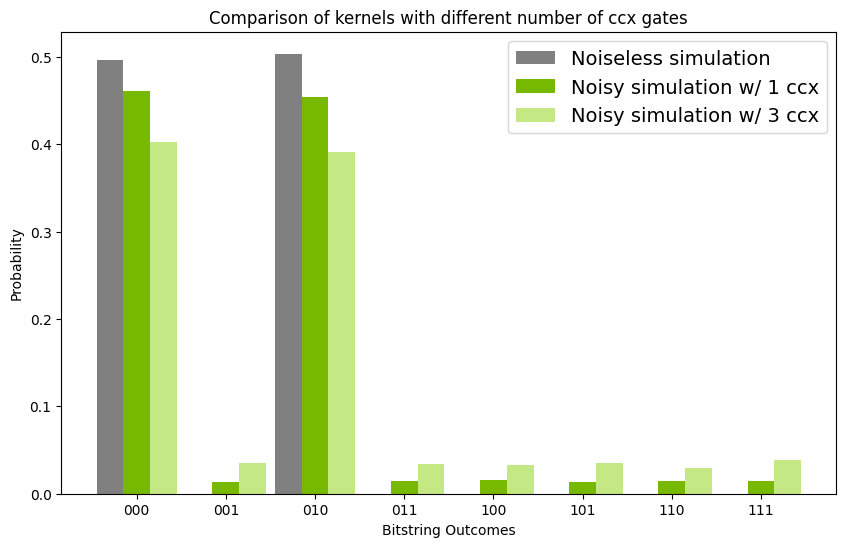

In [29]:
# Merge all bitstrings to ensure consistency across results
bitstrings = sorted(set(result_ccx.keys()) | set(result.keys()) | set(result_ccx3.keys()))

# Function to extract probabilities
def get_probabilities(result, keys):
    total_shots = sum(result.values())
    return [result.get(k, 0) / total_shots for k in keys]

# Extracting probabilities
prob = get_probabilities(result, bitstrings)
prob_ccx = get_probabilities(result_ccx, bitstrings)
prob_ccx3 = get_probabilities(result_ccx3, bitstrings)

# Bar width
bar_width = 0.3
x = np.arange(len(bitstrings))

# Plot bars
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, prob, bar_width, label="Noiseless simulation", color="#808080")
plt.bar(x, prob_ccx, bar_width, label="Noisy simulation w/ 1 ccx", color="#76B900")
plt.bar(
    x + bar_width,
    prob_ccx3,
    bar_width,
    label="Noisy simulation w/ 3 ccx",
    color="#c4e884",
)

# Labels
plt.xticks(x, bitstrings)
plt.xlabel("Bitstring Outcomes")
plt.ylabel("Probability")
plt.title("Comparison of kernels with different number of ccx gates")
plt.legend(fontsize=14)

# Show plot
plt.show()

This histogram represents why unitary compilation is so important.  With a small three qubit example, running three circuits that produce the exact same unitary, the sampled circuits with more multi-qubit gates produce inferior results.  Consider that for a fully scaled up application, good compilation might be the difference between success and a meaningless output or infeasible runtime.  

## Summary

AI has the potential to be a powerful tool for compilation especially at scale. Researchers may be able to use such a tool to better understand the impacts of device noise or identify patterns which make for more favorable circuits.  The AI workflow you explored today is also highly flexible.  It can consider different gate sets, circuit lengths, and many other refinements to improve results. Keep an eye out for future research in this space as different AI techniques are applied to more complex quantum circuit compilation tasks.